In [2]:
!python3 -m pip install --upgrade -r requirements.txt

  Using cached numpy-2.3.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)


In [3]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import pickle, lzma

In [4]:
class CompressedImage:
    def __init__(self, UMatrices: list[np.ndarray], SMatrices: list[np.ndarray], VTMatrices: list[np.ndarray]):
        self.UMatrices: list[np.ndarray] = UMatrices
        self.SMatrices: list[np.ndarray] = SMatrices
        self.VTMatrices: list[np.ndarray] = VTMatrices
        self.num_channels:int = len(UMatrices)

    @classmethod
    def loadImage(self, image: np.ndarray):
        UMatrices: list[np.ndarray] = []
        SMatrices: list[np.ndarray] = []
        VTMatrices: list[np.ndarray] = []
        num_channels:int = image.shape[-1:][0]
        for color_channel in range(num_channels):
            U, s, Vt = np.linalg.svd(image[:,:,color_channel], full_matrices=False)
            UMatrices.append(U)
            SMatrices.append(s)
            VTMatrices.append(Vt)
        return CompressedImage(UMatrices, SMatrices, VTMatrices)

    @classmethod
    def loadImageFile(self, path: str, code: int = -1):
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if code != -1:
            img = cv2.cvtColor(img, code)
        return CompressedImage.loadImage(img)
    
    @classmethod
    def loadCompressedImage(self, path: str,):
        with lzma.open(path, "rb") as dbfile:
            db = pickle.load(dbfile)
        return CompressedImage(db["UMatrices"], db["SMatrices"], db["VTMatrices"])

    def kthLayer(self, k:int) -> np.ndarray:
        channels: list[np.ndarray] = []
        for color_channel in range(self.num_channels):
            channels.append(self.SMatrices[color_channel][k] * np.outer(self.UMatrices[color_channel][:,k], self.VTMatrices[color_channel][k,:]))
        return np.stack(channels, axis=2)

    def kLayerApproximation(self, k:int, sanatize = True) -> np.ndarray:
        approximation: np.ndarray = np.zeros((self.UMatrices[0].shape[0], self.VTMatrices[0].shape[1], self.num_channels), dtype=float)
        for layerK in range(k):
            approximation += self.kthLayer(layerK)
        if sanatize:
            return np.clip(approximation, 0, 255).astype(np.uint8)
        return approximation
    
    def saveImage(self, path:str, maxK: int) -> None:
        db = {}
        if(maxK == -1):
            maxK = min(self.UMatrices[0].shape[1], self.VTMatrices[0].shape[0])
        db['UMatrices'] = [arr[:, :maxK] for arr in self.UMatrices]
        db['SMatrices'] = [arr[:maxK] for arr in self.SMatrices]
        db['VTMatrices'] = [arr[:maxK,:]for arr in self.VTMatrices]
        with lzma.open(path, "wb") as dbfile:
            pickle.dump(db, dbfile)                    
        dbfile.close()
        return os.path.getsize(path)

    def maxApproximation(self) -> np.ndarray:
        return self.kLayerApproximation(self.getMaxK())
    
    def getMaxK(self) -> int:
        return min(self.UMatrices[0].shape[1], self.VTMatrices[0].shape[0])
    
    def getDim(self) -> tuple[int, int]:
        return (self.UMatrices[0].shape[0], self.VTMatrices[0].shape[1])
    
    def getNumBytes(self, k = -1) -> int:
        if k == -1:
            k = self.getMaxK()
        numBytes:int = 0
        for color_channel in range(self.num_channels):
            numBytes += self.UMatrices[color_channel][:,:k].nbytes
            numBytes += self.VTMatrices[color_channel][:k,:].nbytes
            numBytes += self.SMatrices[color_channel][:k].nbytes
        return numBytes



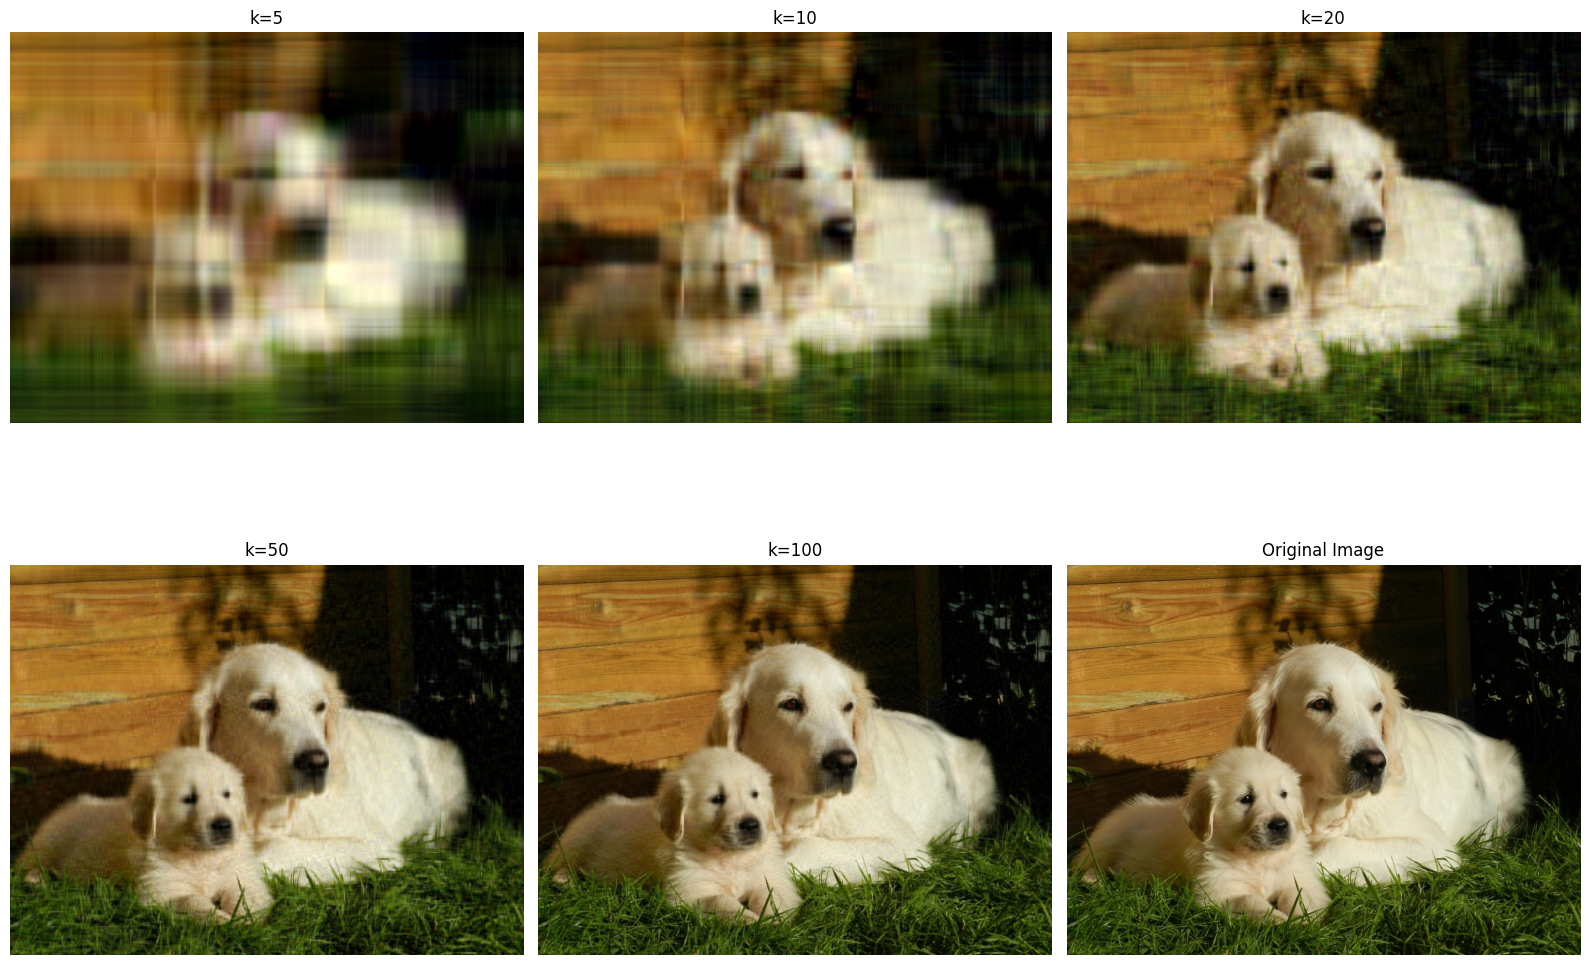

In [5]:
originalImage = cv2.imread(os.path.join("images", "colordog.png"))
originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
dog = CompressedImage.loadImage(originalImage)

rows = 2
cols = 3

displaySteps = [5, 10, 20, 50, 100]
plt.figure(figsize=(8*rows, 4*cols))

approximation: np.ndarray = np.zeros(originalImage.shape)
for k in range(displaySteps[-1]):
    approximation += dog.kthLayer(k)
    if k + 1 in displaySteps:
        plt.subplot(rows, cols, displaySteps.index(k + 1) + 1)
        plt.imshow(np.clip(approximation, 0, 255).astype(np.uint8))
        plt.title("k=" + str(k + 1))
        plt.axis('off')

plt.subplot(rows, cols, rows*cols)
plt.imshow(originalImage)
plt.title("Original Image")
plt.axis('off')

plt.tight_layout()
plt.show()

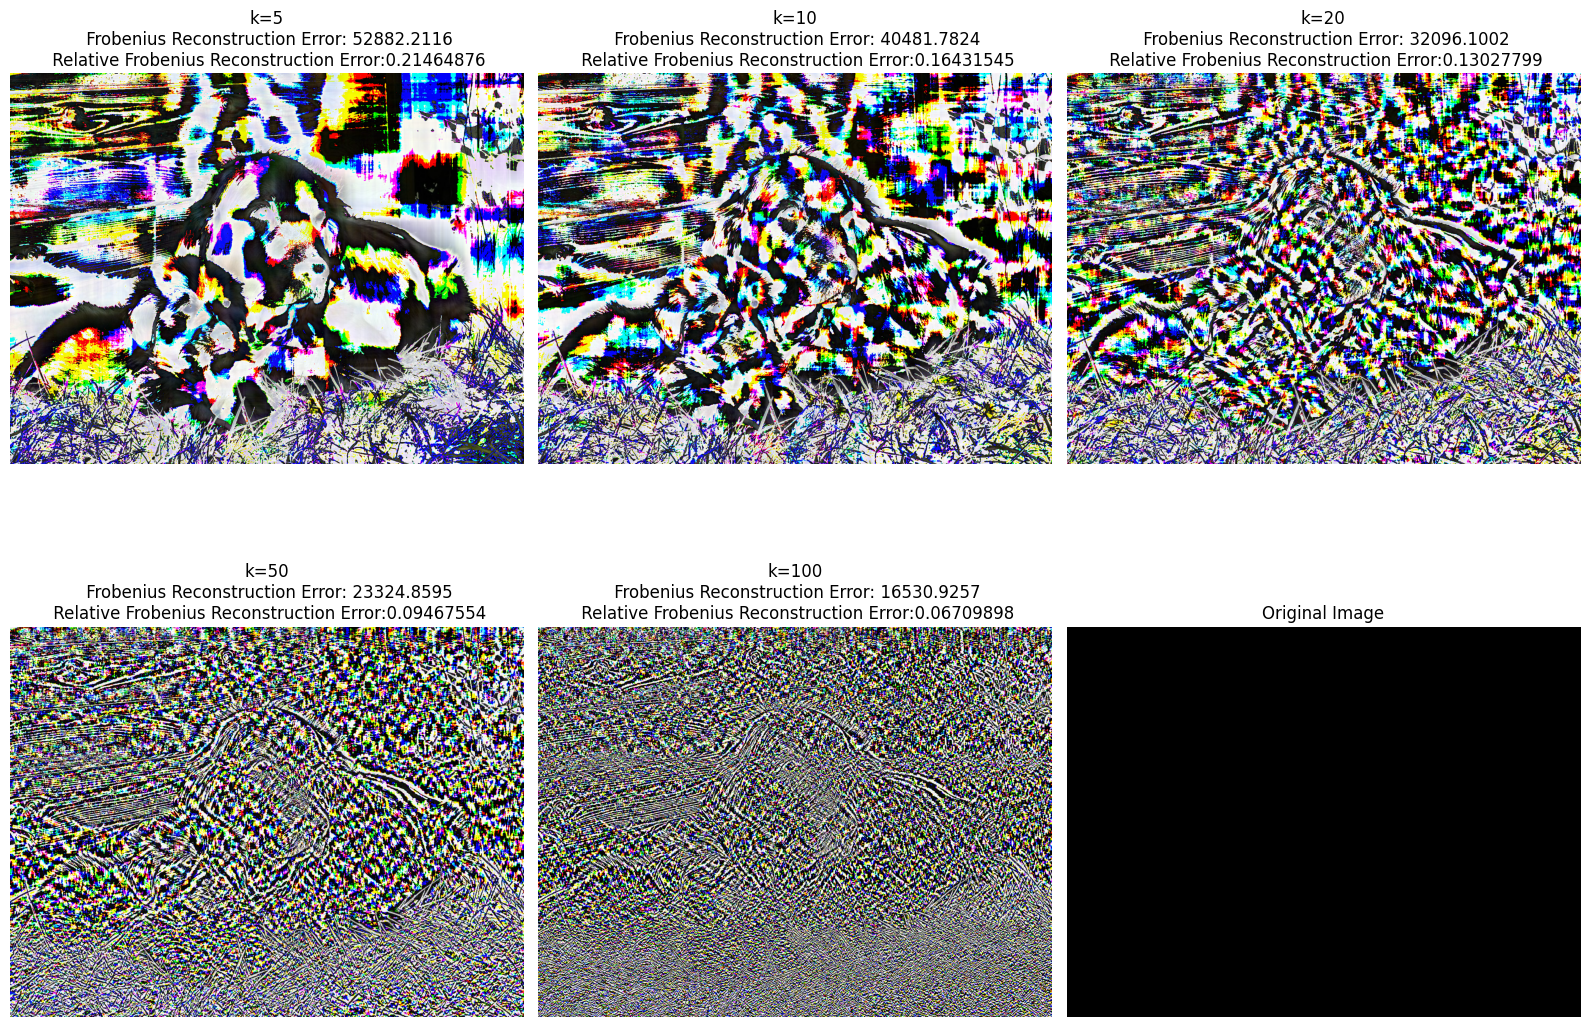

In [6]:
rows = 2
cols = 3

displaySteps = [5, 10, 20, 50, 100]
plt.figure(figsize=(8*rows, 4*cols))

approximation: np.ndarray = np.zeros(originalImage.shape)
for k in range(displaySteps[-1]):
    approximation += dog.kthLayer(k)
    if k + 1 in displaySteps:
        plt.subplot(rows, cols, displaySteps.index(k + 1) + 1)
        diff = originalImage - approximation
        plt.imshow(originalImage - np.clip(approximation, 0, 255).astype(np.uint8))
        plt.title("k=" + str(k + 1) 
                  + "\n Frobenius Reconstruction Error: " + str(np.linalg.norm(diff))[:10]
                  + "\n Relative Frobenius Reconstruction Error:" + str(np.linalg.norm(diff)/np.linalg.norm(originalImage))[:10])
        plt.axis('off')

plt.subplot(rows, cols, rows*cols)
plt.imshow(originalImage - originalImage)
plt.title("Original Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
#Converts to np.float32 to avoid underflow 
def relativeFrobeniusError(a: np.ndarray, b: np.ndarray) -> float:
    aF = a.astype(np.float32)
    bF = b.astype(np.float32)
    return float(np.linalg.norm(aF - bF) / np.linalg.norm(aF))

In [8]:
relativeFrobeniusErr:list[float] = [0]*dog.getMaxK()
compressionRatio:list[float] = [0]*dog.getMaxK()
approximation: np.ndarray = np.zeros(originalImage.shape)
for k in range(dog.getMaxK()):
    approximation += dog.kthLayer(k)
    relativeFrobeniusErr[k] = relativeFrobeniusError(originalImage, approximation)
    compressionRatio[k] = (originalImage.nbytes - dog.getNumBytes(k))/originalImage.nbytes

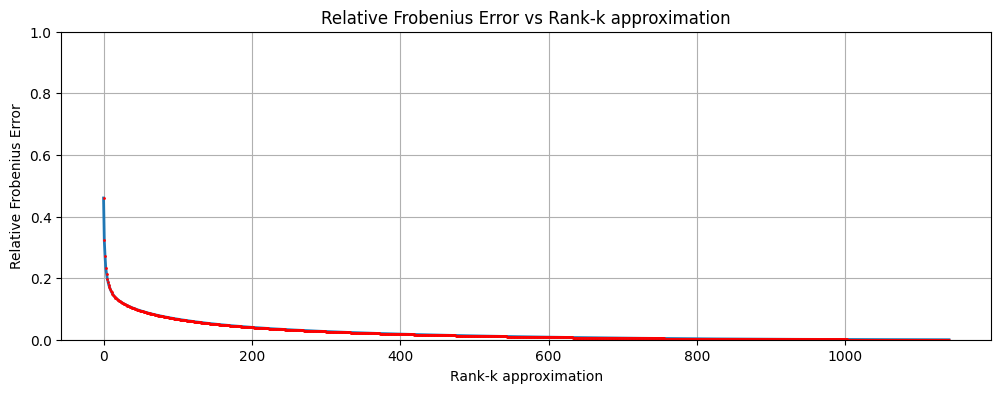

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(relativeFrobeniusErr, marker='o', markersize=1, markeredgecolor='red', linewidth=2)
plt.ylim(0, 1)
plt.xlabel("Rank-k approximation")
plt.ylabel("Relative Frobenius Error")
plt.title("Relative Frobenius Error vs Rank-k approximation")
plt.grid(True)
plt.show()

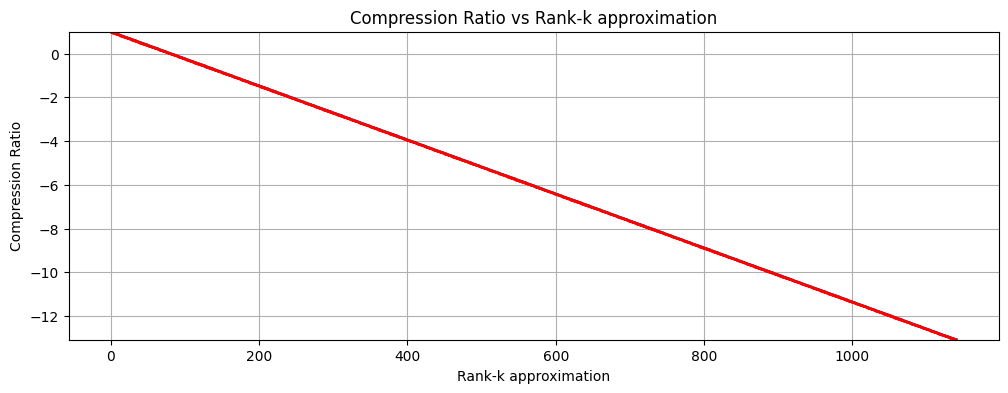

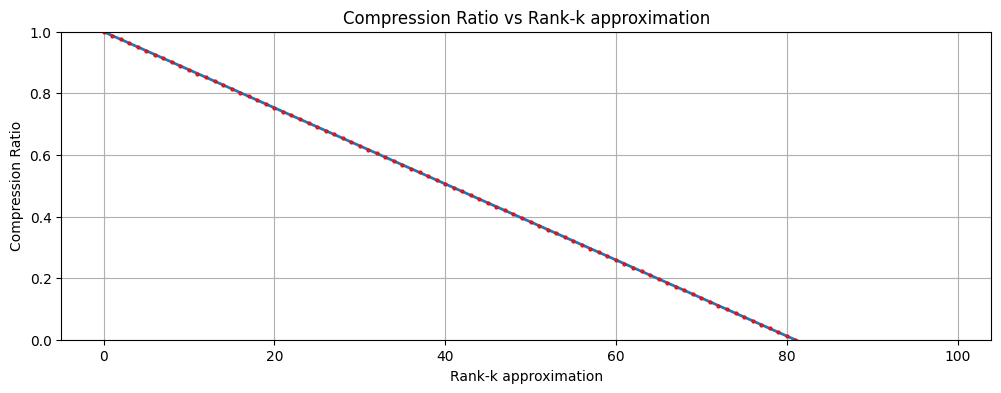

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(compressionRatio, marker='o', markersize=1, markeredgecolor='red', linewidth=2)
plt.ylim(min(compressionRatio), 1)
plt.xlabel("Rank-k approximation")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs Rank-k approximation")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(compressionRatio[:100], marker='o', markersize=2, markeredgecolor='red', linewidth=2)
plt.ylim(0, 1)
plt.xlabel("Rank-k approximation")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs Rank-k approximation")
plt.grid(True)
plt.show()

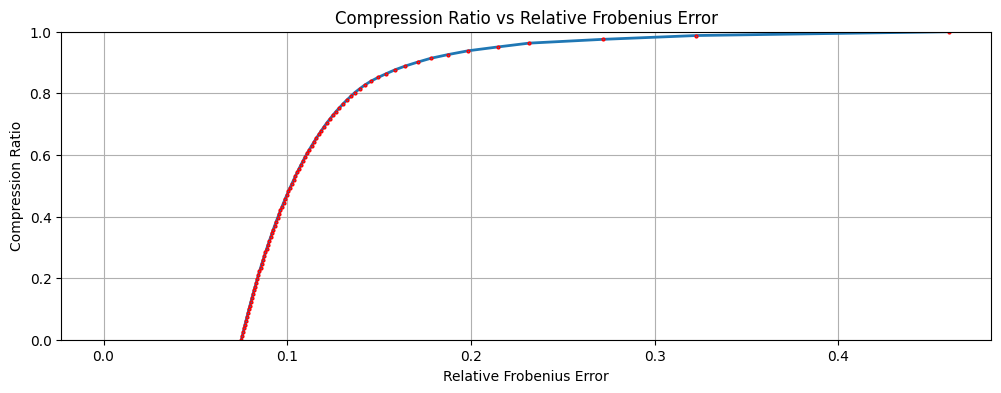

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(relativeFrobeniusErr, compressionRatio, label = "WEBP",  marker='o', markersize=2, markeredgecolor='red', linewidth=2)

plt.ylim(0, 1)
plt.xlabel("Relative Frobenius Error")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs Relative Frobenius Error")
plt.grid(True)

plt.show()

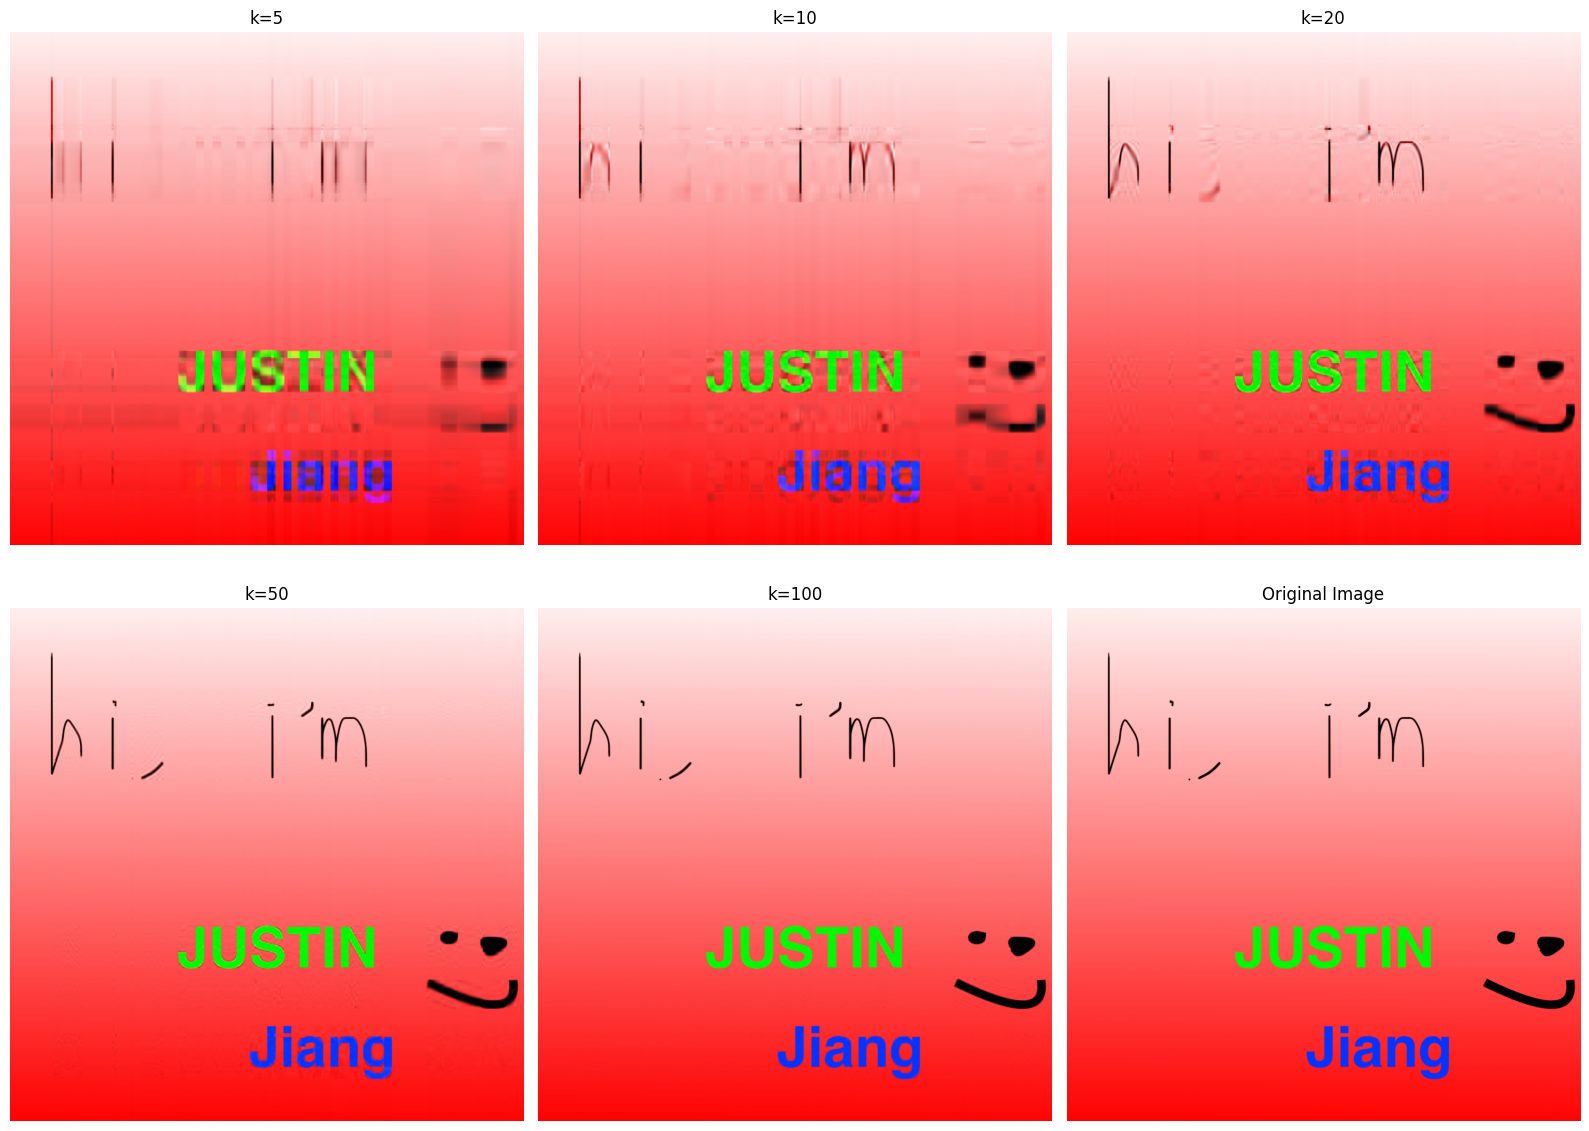

In [13]:
alphaImage = cv2.imread(os.path.join("images", "redalpha.png"), cv2.IMREAD_UNCHANGED)
alphaImage = cv2.cvtColor(alphaImage, cv2.COLOR_BGRA2RGBA)
compressedAlphaImage = CompressedImage.loadImage(alphaImage) 

rows = 2
cols = 3

displaySteps = [5, 10, 20, 50, 100]
plt.figure(figsize=(8*rows, 4*cols))

approximation: np.ndarray = np.zeros(alphaImage.shape)
for k in range(displaySteps[-1]):
    approximation += compressedAlphaImage.kthLayer(k)
    if k + 1 in displaySteps:
        plt.subplot(rows, cols, displaySteps.index(k + 1) + 1)
        plt.imshow(np.clip(approximation, 0, 255).astype(np.uint8))
        plt.title("k=" + str(k + 1))
        plt.axis('off')

plt.subplot(rows, cols, rows*cols)
plt.imshow(alphaImage)
plt.title("Original Image")
plt.axis('off')

plt.tight_layout()
plt.show()